# Actividad - Proyecto práctico


> La actividad se desarrollará en grupos pre-definidos de 2-3 alumnos. Se debe indicar los nombres en orden alfabético (de apellidos). Recordad que esta actividad se corresponde con un 30% de la nota final de la asignatura. Se debe entregar entregar el trabajo en la presente notebook.
*   Alumno 1: Marta Castillo Galán
*   Alumno 2: Unai Marín Etxebarria
*   Alumno 3: Laura Molinos Mayo
*   Alumno 4: Raúl Murillo Gallego






---
## **PARTE 2**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, el requisito mínimo será alcanzado cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

1.   Implementar la red neuronal que se usará en la solución
2.   Implementar las distintas piezas de la solución DQN
3.   Justificar la respuesta en relación a los resultados obtenidos

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada. El requisito mínimo servirá para aprobar la actividad, bajo premisa de que la discusión del resultado sera apropiada.

IMPORTANTE:

* Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.
* Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).
* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.

---
## **PARTE 3**. Desarrollo y preguntas

#### Importar librerías

In [1]:
from __future__ import division

from PIL import Image
import numpy as np
import gym

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

#### Configuración base

In [2]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [3]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

1. Implementación de la red neuronal

In [4]:
def build_model(window_length, input_shape, nb_actions):
    model = Sequential()
    model.add(Permute((2, 3, 1), input_shape=(window_length,) + input_shape))  # (window, 84, 84) → (84, 84, window)
    model.add(Convolution2D(32, (8, 8), strides=(4, 4), activation='relu'))
    model.add(BatchNormalization())
    model.add(Convolution2D(64, (4, 4), strides=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Convolution2D(64, (3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(nb_actions, activation='linear'))
    return model

2. Implementación de la solución DQN

In [5]:
# Preparamos memoria y política
memory = SequentialMemory(limit=25000, window_length=WINDOW_LENGTH)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(),
                              attr='eps',
                              value_max=1.0,
                              value_min=0.1,
                              value_test=0.05,
                              nb_steps=200000) 

# Creamos el modelo
model = build_model(WINDOW_LENGTH, INPUT_SHAPE, nb_actions)
print(model.summary())

# Creamos el procesador
processor = AtariProcessor()

#Creamos el agente
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               policy=policy,
               memory=memory,
               processor=processor,
               nb_steps_warmup = 3000,
               gamma=0.99,
               target_model_update=5000,
               train_interval=1,
               delta_clip=1.0,
               enable_double_dqn=True)

dqn.compile(Adam(learning_rate=0.0001), metrics=['mae'])

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute (Permute)            (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 32)        8224      
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 20, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
__________________________________________________

In [6]:
history=dqn.fit(env, nb_steps=200000, visualize=False, verbose=2)

Training for 200000 steps ...


C:\Users\laura\anaconda3\envs\miar_rl\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


    420/200000: episode: 1, duration: 2.894s, episode steps: 420, steps per second: 145, episode reward:  6.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 2.474 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    980/200000: episode: 2, duration: 3.383s, episode steps: 560, steps per second: 166, episode reward:  5.000, mean reward:  0.009 [ 0.000,  1.000], mean action: 2.400 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   1596/200000: episode: 3, duration: 3.517s, episode steps: 616, steps per second: 175, episode reward:  7.000, mean reward:  0.011 [ 0.000,  1.000], mean action: 2.445 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   2373/200000: episode: 4, duration: 4.206s, episode steps: 777, steps per second: 185, episode reward: 12.000, mean reward:  0.015 [ 0.000,  1.000], mean action: 2.394 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   2866/200000: episode: 5, duration: 2.733s, episode steps: 493, steps per 

C:\Users\laura\anaconda3\envs\miar_rl\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


   3559/200000: episode: 6, duration: 93.374s, episode steps: 693, steps per second:   7, episode reward:  9.000, mean reward:  0.013 [ 0.000,  1.000], mean action: 2.579 [0.000, 5.000],  loss: 0.068304, mae: 0.207481, mean_q: 0.342553, mean_eps: 0.985242
   4397/200000: episode: 7, duration: 133.825s, episode steps: 838, steps per second:   6, episode reward: 13.000, mean reward:  0.016 [ 0.000,  1.000], mean action: 2.409 [0.000, 5.000],  loss: 0.006069, mae: 0.037766, mean_q: 0.067434, mean_eps: 0.982101
   5299/200000: episode: 8, duration: 184.974s, episode steps: 902, steps per second:   5, episode reward: 17.000, mean reward:  0.019 [ 0.000,  1.000], mean action: 2.513 [0.000, 5.000],  loss: 0.006185, mae: 0.034541, mean_q: 0.064471, mean_eps: 0.978186
   5819/200000: episode: 9, duration: 88.191s, episode steps: 520, steps per second:   6, episode reward: 11.000, mean reward:  0.021 [ 0.000,  1.000], mean action: 2.481 [0.000, 5.000],  loss: 0.007889, mae: 0.046756, mean_q: 0.0

In [7]:
#Evaluación en modo test
scores = dqn.test(env, nb_episodes=20, visualize=False)
print("Media de recompensa:", np.mean(scores.history['episode_reward']))

Testing for 20 episodes ...
Episode 1: reward: 9.000, steps: 692
Episode 2: reward: 13.000, steps: 958
Episode 3: reward: 7.000, steps: 597
Episode 4: reward: 3.000, steps: 524
Episode 5: reward: 6.000, steps: 577
Episode 6: reward: 6.000, steps: 628
Episode 7: reward: 17.000, steps: 1017
Episode 8: reward: 4.000, steps: 403
Episode 9: reward: 4.000, steps: 570
Episode 10: reward: 9.000, steps: 662
Episode 11: reward: 9.000, steps: 659
Episode 12: reward: 9.000, steps: 708
Episode 13: reward: 3.000, steps: 694
Episode 14: reward: 3.000, steps: 534
Episode 15: reward: 4.000, steps: 448
Episode 16: reward: 6.000, steps: 610
Episode 17: reward: 16.000, steps: 1040
Episode 18: reward: 6.000, steps: 447
Episode 19: reward: 6.000, steps: 413
Episode 20: reward: 14.000, steps: 1081
Media de recompensa: 7.7


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


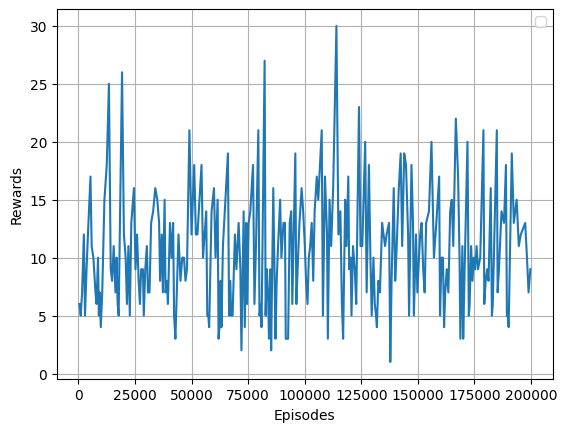

In [11]:
rewards = history.history['episode_reward']
steps = history.history['nb_steps']

# Crear el gráfico
plt.plot(steps, rewards)
plt.xlabel('Steps')
plt.ylabel('Rewards')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
#Guardado de pesos
dqn.save_weights('dqn_spaceinvaders_weights.h5f', overwrite=True)

3. Justificación de los parámetros seleccionados y de los resultados obtenidos

---